This script mostly works, but not always. Sometimes the images are weird and half-white. I could maybe do some more work but this is a good start.

In [321]:
import math
import requests
from PIL import Image
from requests.auth import HTTPBasicAuth
import os
import json
from io import BytesIO


In [322]:
lat = -16.983333
lon = 35.208332
zoom = 14 # api supports up to 18 but the images aren't clear past 14

min_year = 2016
min_month = 7 # January

max_year = 2016
max_month = 8 # December

api_key = None
with open('api_key.txt') as f:
    api_key = f.readlines()[0].strip()
    
item_type = 'PSScene3Band'

In [323]:
if min_month < 10:
    min_month = '0' + str(min_month)

if max_month < 10:
    max_month = '0' + str(max_month)

In [324]:
def create_cords(lat, lon):
    amt = 0.0005
    lat_down = lat - amt*10
    lat_up = lat + amt*10
    
    lon_left = lon - amt/10
    lon_right = lon + amt/10
    
    return [[lon_left, lat_down], [lon_right, lat_down], [lon_right, lat_up], [lon_left, lat_up]]

In [325]:
geo_json_geometry = {
  "type": "Polygon",
  "coordinates": [
      create_cords(lat, lon)
  ],
    
}

# filter for items the overlap with our chosen geometry
geometry_filter = {
  "type": "GeometryFilter",
  "field_name": "geometry",
  "config": geo_json_geometry,
}

# filter images acquired in a certain date range
date_range_filter = {
  "type": "DateRangeFilter",
  "field_name": "acquired",
  "config": {
    "gte": "{}-{}-01T00:00:00.000Z".format(min_year, min_month),
    "lte": "{}-{}-01T00:00:00.000Z".format(max_year, max_month)
  }
}

# filter any images which are more than 50% clouds
cloud_cover_filter = {
  "type": "RangeFilter",
  "field_name": "cloud_cover",
  "config": {
    "lte": 0.2
  }
}

# create a filter that combines our geo and date filters
# could also use an "OrFilter"
reservoir = {
  "type": "AndFilter",
  "config": [geometry_filter, date_range_filter, cloud_cover_filter]
}

In [326]:
# Search API request object
search_endpoint_request = {
  "item_types": [item_type],
  "filter": reservoir
}

result = \
  requests.post(
    'https://api.planet.com/data/v1/quick-search',
    auth=HTTPBasicAuth(os.environ['PL_API_KEY'], ''),
    json=search_endpoint_request)

In [327]:
res = json.loads(result.text)

In [328]:
item_id = None

if len(res['features']) == 0:
    print('No image found')
else:
    item_id = res['features'][0]['id']

In [329]:
def deg_to_tile(lat_deg, lon_deg, zoom):
    """Converts coordinates into the nearest x,y Slippy Map tile"""
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad)))
                 / math.pi) / 2.0 * n)
    return (xtile, ytile)

In [330]:
x, y = deg_to_tile(lat, lon, zoom)

In [331]:
(item_type, item_id, zoom, x, y)

('PSScene3Band', '20160702_125402_0c64', 14, 9794, 8976)

In [332]:
url = 'https://tiles0.planet.com/data/v1/{}/{}/{}/{}/{}.png?api_key={}'.format(item_type, item_id, zoom, x, y, api_key)


In [333]:
res = requests.get(url)
if res.status_code >= 400:
    print('download error')

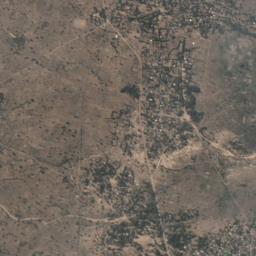

In [335]:
image = Image.open(BytesIO(res.content))
image